In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.patches import Patch
import seaborn as sns
from itertools import combinations
from pca_analyzer import PcaAnalyzer
from sklearn.cluster import KMeans
import plotly.express as px
from plotly import offline

In [2]:
from geography_helper import import_GA_boundary_file, places_to_geom
GA = import_GA_boundary_file('GAboundary.txt')
GApd = gpd.GeoDataFrame(data = pd.DataFrame({'state':['GA']}), geometry = [GA])

In [3]:
features = pd.read_csv('combined_features.csv', index_col = 0)
coords = features[['latitude', 'longitude']]

In [4]:
def feature_grapher(features, dims, fig = None, ax = None, legend = False, fontsize = 14, **kwargs):
        if len(dims) != 3:
            raise ValueError("Please pass exactly 3 indices")
            
        colnames = list(features.columns)

        x = features.iloc[:, dims[0]-1]
        y = features.iloc[:, dims[1]-1]
        z = features.iloc[:, dims[2]-1]
        
        if (not fig) or (not ax):
            fig = plt.figure(figsize=(12,10))
            ax = fig.add_subplot(111, projection="3d")

        scatter = ax.scatter(x,y,z, marker="o", **kwargs)
        ax.set_title(f"Projection to principal components {dims[0]}, {dims[1]}, and {dims[2]}", fontsize = fontsize)

        ax.set_xlabel(colnames[dims[0]-1])
        ax.set_ylabel(colnames[dims[1]-1])
        ax.set_zlabel(colnames[dims[2]-1])
        
        if legend:
            legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Cluster")
        
        plt.show()

In [5]:
def component_plotter(loading_series, fig, ax):
    norm1toneg1 = colors.TwoSlopeNorm(vmin= -1, vcenter=0., vmax=1)
    mappable = cm.ScalarMappable(norm = norm1toneg1, cmap = cm.Spectral)

    ax.imshow(loading_series.repeat(3).reshape(-1,3), cmap = mappable.get_cmap(), norm = norm1toneg1)

    for j in range(len(loading_series)):
        text = ax.text(1, j, f'{loading_series[j]:.2f}',
            ha='center', va="center", color="black")

    ax.set_yticks(np.arange(len(keep_list)), labels=keep_list)
    ax.set_xticks([], [])       
    fig.colorbar(mappable)

    plt.show()

# Subset cols and impute

In [6]:
X = features.select_dtypes(include=np.number).drop(['latitude', 'longitude'], axis = 1)

In [7]:
X['Transit Score'] = X['Transit Score'].fillna(0)
# X['year_built'] = X['year_built'].fillna(np.median(features.year_built.dropna()))
X['beds'] = X['beds'].fillna(np.median(features.beds.dropna()))
X['square_footage'] = X['square_footage'].fillna(np.median(features.square_footage.dropna()))
X['baths'] = X['baths'].fillna(np.median(features.baths.dropna()))
X['Walk Score'] = X['Walk Score'].fillna(np.median(features['Walk Score'].dropna()))
X['property_crime_total_rate'] = X['property_crime_total_rate']\
    .fillna(np.median(features['property_crime_total_rate'].dropna()))
X['property_crime_theft_rate'] = X['property_crime_theft_rate']\
    .fillna(np.median(features['property_crime_theft_rate'].dropna()))

# Log columns

In [8]:
# col = (col for col in X.columns)

In [9]:
# current_col = next(col)
# X[current_col].hist(bins = 50)
# plt.title(f'Distribution of {current_col}')
# plt.show()
# print(current_col)

In [10]:
log_cols = ['price',
    'square_footage',
'dist_to_good_e_school',
'Walk Score',
'dist_to_park',
'dist_to_mall',
'dist_to_attraction',
'dist_to_transit',
'num_sb_within_5',
'num_wb_within_5',
'num_wh_within_5',
'num_brew_within_5',
'num_wb_brew_within_5',
'posh_total',
'property_crime_total_rate',
'property_crime_theft_rate'
]

In [11]:
for col in [col for col in log_cols if col in  X.columns]:
    X[f"log({col}+1)"] = np.log(X[col]+1)
X.drop([col for col in log_cols if col in  X.columns], axis = 1, inplace = True)

In [12]:
# col_log = (col_log for col_log in log_cols)

In [13]:
# current_log_col = next(col_log)
# X[f"log({current_log_col}+1)"].hist(bins = 50)
# plt.title(f'Distribution of log({current_log_col}+1)')
# plt.show()

## Check scales + select features

In [14]:
# larger_range = ['EAL_ratio']

EAL_ratio has a very wide distribution with many outside 2 std.

In [15]:
keep_list = [ 'log(price+1)',  'log(square_footage+1)','beds',
 'baths',
 'EAL_ratio',
 'avg_nearby_school_rating',
 'closest_school_rating',
 'log(dist_to_good_e_school+1)',
 'log(Walk Score+1)',
 'Transit Score',
 'log(dist_to_transit+1)',
 'num_nearby_attractions',
 'log(posh_total+1)',
 'log(num_brew_within_5+1)',
 'log(num_wb_within_5+1)',
 'log(property_crime_total_rate+1)',
 'log(property_crime_theft_rate+1)']

In [16]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler= StandardScaler()
# transformed = scaler.fit_transform(X[keep_list])
# transformed = pd.DataFrame(transformed, columns = scaler.get_feature_names_out())

# col = (col for col in transformed)

In [17]:
# %matplotlib inline

# fig, ax = plt.subplots(figsize = (5,5))
# transformed[next(col)].hist(bins = 30, ax = ax)
# plt.title(next(col))
# plt.show()

In [18]:
# comb = combinations(np.arange(len(keep_list))+1, 3)

In [19]:
# %matplotlib widget
# feature_grapher(transformed, list(next(comb)))

# Run PCA

In [20]:
pca = PcaAnalyzer(X[keep_list])
pca_features = pd.concat([coords, pca.pca_df], axis = 1)
X_5 = pca.pca_df.iloc[:,:5]
pca_coord = pd.concat([coords, X_5], axis =1)
pc = pca.pca.components_
pca.total_var(5)

There are 17 components numbered 1 through 17


0.7832358908706178

Proportion of variance explained by the 17 PCA components (largest to smallest)
[0.34565122 0.20790959 0.10948344 0.06467665 0.05551499 0.04707727
 0.0327797  0.0293273  0.02213324 0.01723238 0.0154196  0.0143122
 0.01399719 0.01058626 0.00966902 0.00317816 0.00105177]
Cumulative variance explained by the 17 PCA components (largest to smallest)
[0.34565122 0.55356081 0.66304425 0.7277209  0.78323589 0.83031317
 0.86309287 0.89242017 0.91455341 0.93178579 0.94720539 0.96151759
 0.97551478 0.98610104 0.99577006 0.99894823 1.        ]


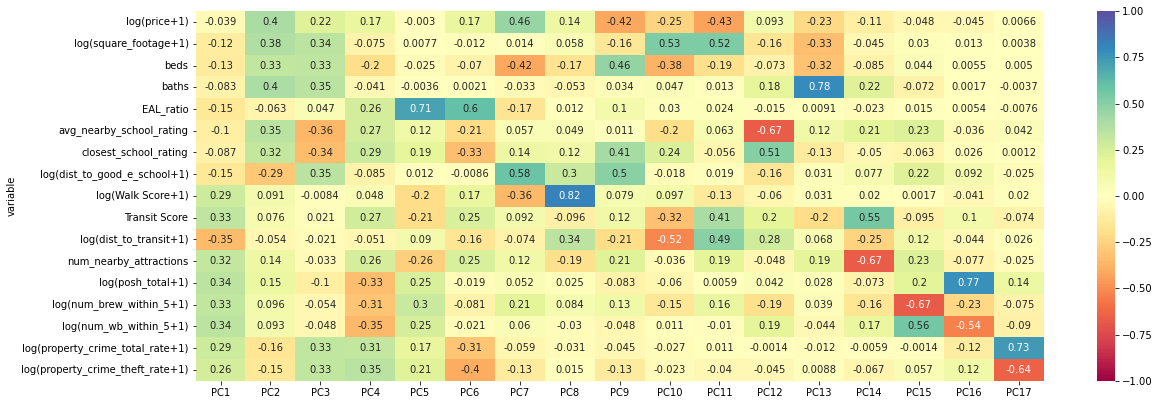

Scree plot


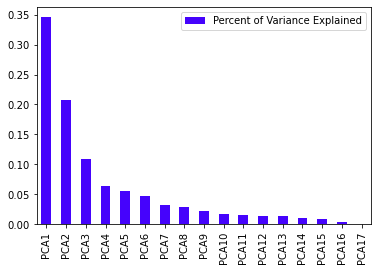

In [21]:
loadings = pca.pca_explainer()

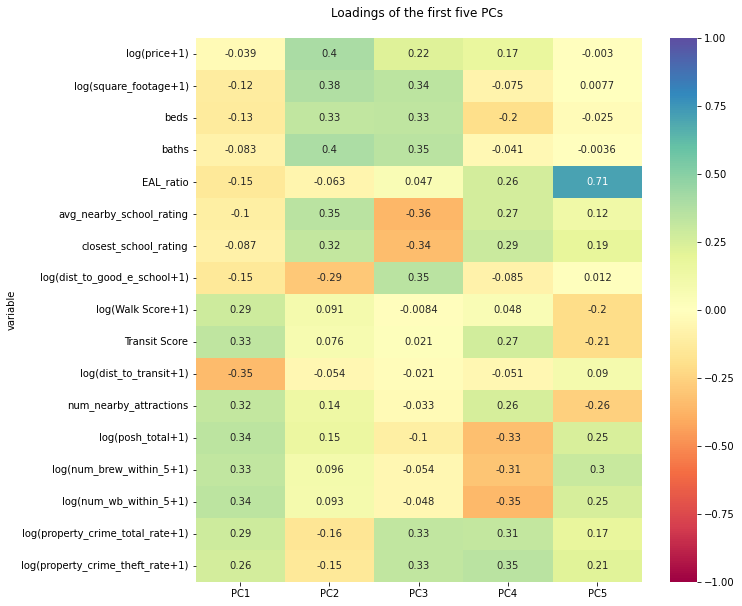

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(loadings.iloc[:,:5], vmin = -1, center = 0, vmax = 1, cmap = 'Spectral', annot = True, ax = ax)
plt.title('Loadings of the first five PCs \n')
plt.savefig('all_pca.png', dpi=320, 
        bbox_inches='tight', pad_inches=0.1)

# PCs

In [23]:
components = (col for col in X_5.columns)

(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

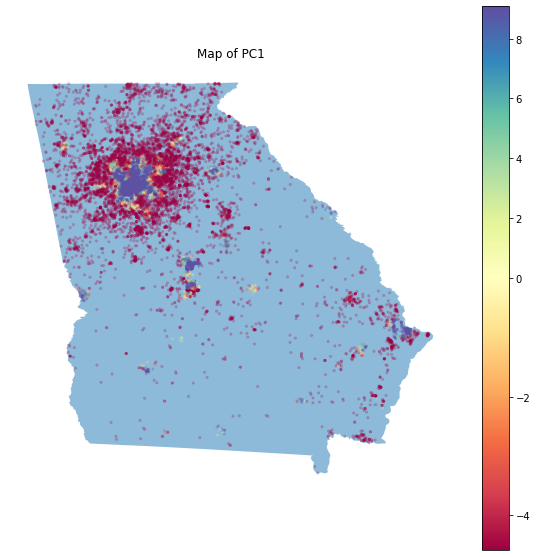

In [24]:
%matplotlib inline
component = next(components)
values = pca_coord[component]

mappable = cm.ScalarMappable(norm = colors.TwoSlopeNorm(vmin=values.min(), vcenter=0., vmax=values.max()), cmap = cm.Spectral)

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(pca_coord).plot(ax = ax, markersize = 5, alpha = .2, c = mappable.get_cmap()(values))
fig.colorbar(mappable, ax=ax)
ax.set(title = f'Map of {component}')
plt.axis('off')

<AxesSubplot:>

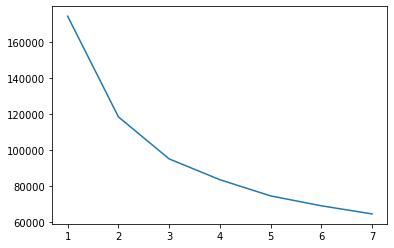

In [25]:
%matplotlib inline
wcss = []

for i in range(1, 8):
    clustering = KMeans(n_clusters=i, random_state=42)
    clustering.fit(X_5)
    wcss.append(clustering.inertia_)
    
ks = [*range(1,8)]
sns.lineplot(x = ks, y = wcss)

In [26]:
kmeans = KMeans(n_clusters = 3, random_state = 7)
major_groups = np.array(kmeans.fit_predict(X_5))
major_clusters = pd.concat([X_5,pd.Series(major_groups,name = 'major_cluster')],axis = 1)
triple = colors.ListedColormap(cm.Set1([1,2,3]))
group_colors = cm.Set1(major_groups + 1)

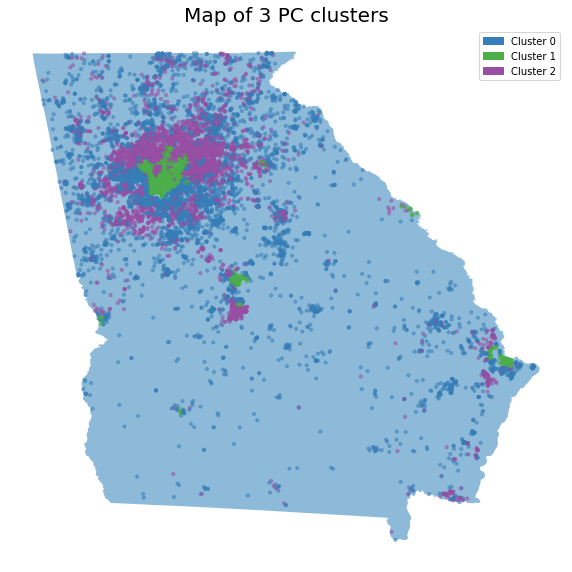

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(coords).plot(c = group_colors, ax = ax, alpha = .5, markersize = 10)
# ctx.add_basemap(ax)
plt.title('Map of 3 PC clusters', fontsize = 20)

cluster0 = Patch(color=cm.Set1(1), label='Cluster 0')
cluster1 = Patch(color=cm.Set1(2), label='Cluster 1')
cluster2 = Patch(color=cm.Set1(3), label='Cluster 2')
plt.legend(handles=[cluster0, cluster1, cluster2])

plt.axis('off')
plt.savefig('pc123_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

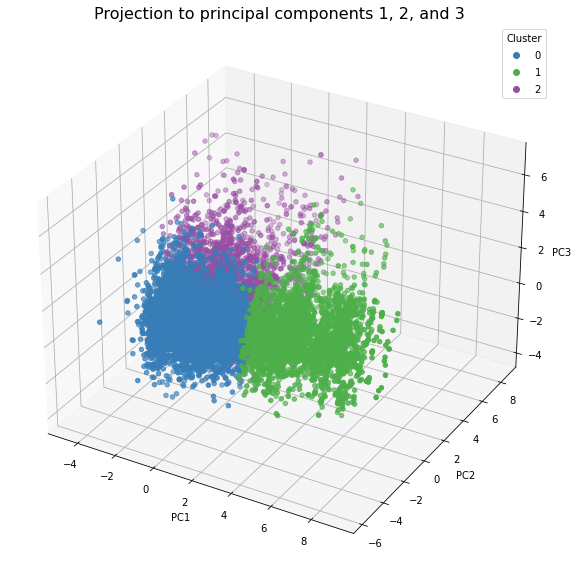

In [28]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111,projection = '3d')
feature_grapher(X_5, [1,2,3], c = major_groups, cmap = triple, legend = True, fig = fig, ax = ax, fontsize = 16)
fig.savefig('pc123.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01 )

In [29]:
#plotly version
px_colors = [*map(lambda x: f'rgb({x[0]}, {x[1]}, {x[2]})', 255 * cm.Set1(np.arange(3)+1))]
fig = px.scatter_3d(pd.concat([pca.pca_df,pd.Series(np.char.array('Cluster ') + np.char.array(major_groups.astype('str')), name = 'Cluster')], axis = 1), 
                    x='PC1', y='PC2', z='PC3', opacity = .8,
                    color = 'Cluster',
                    color_discrete_sequence=px_colors, 
                    category_orders={'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2']},
                    title = 'PCs 1, 2, and 3'
                   )

fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.update_layout(legend= {'itemsizing': 'constant'})
offline.plot(fig, include_plotlyjs='cdn', filename = 'pc_123.html')
# offline.plot(fig, filename='pc_123.html')

'pc_123.html'

In [30]:
# with open('pc_plotly_clusters.txt', 'w') as f:
#     f.write(fig.to_json())

In [31]:
# component = 5
# pca.scree_plot(component = component)
# pca.total_var(component)

In [32]:
comb = combinations([1,2,3,4,5], 3)

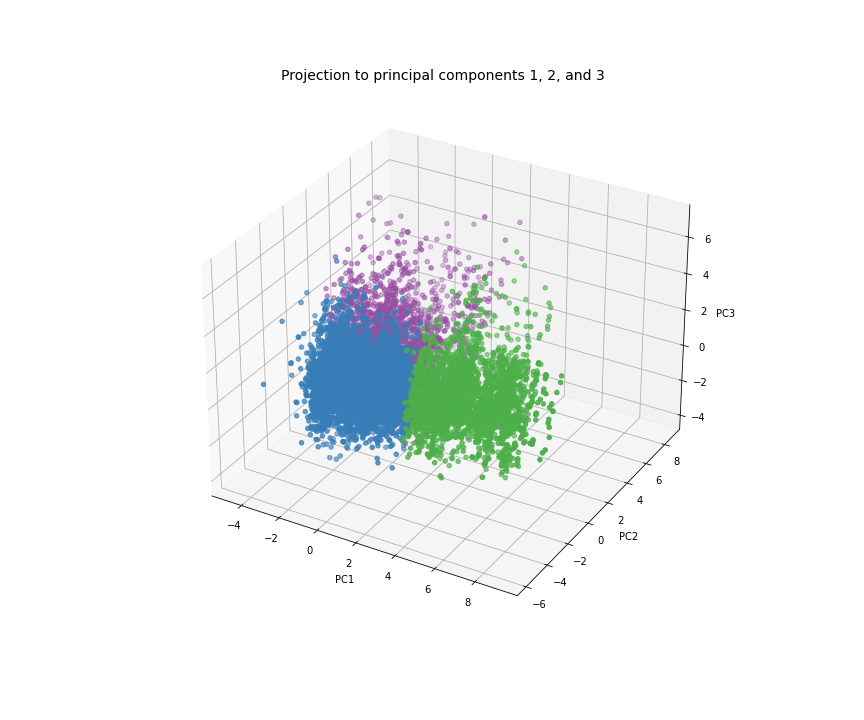

In [33]:
%matplotlib widget
feature_grapher(pca.pca_df, list(next(comb)), c = group_colors)

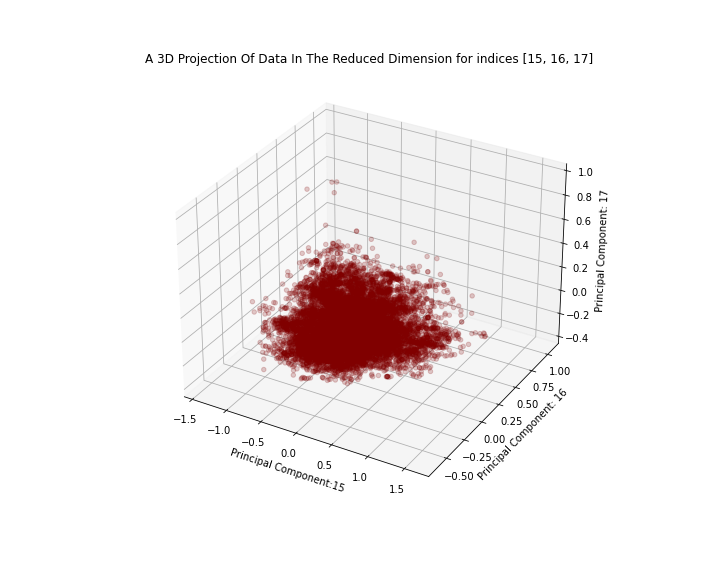

In [34]:
%matplotlib widget
pca.pca_grapher([15,16,17])

## 1,2,3

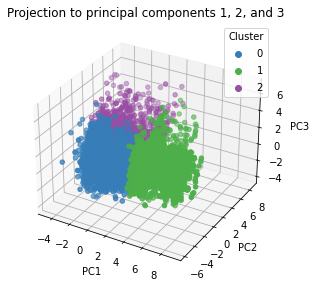

In [35]:
%matplotlib inline

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(121,projection = '3d')
feature_grapher(X_5, [1,2,3], c = major_groups, cmap = triple, legend = True, fig = fig, ax = ax1, fontsize = 12)
fig.savefig('pc123.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01 )

ax2 = fig.add_subplot(122)
ax2.scatter(pca.pca_df.PC1, pca.pca_df.PC2, c = group_colors, alpha = .3)

t = np.linspace(0, 2*np.pi, 100)
x = 4*np.cos(t)
y = 4*np.sin(t)
ax2.plot(x,y, c = 'red', linestyle = '--')

ax2.set(title = 'PC1 vs. PC2', aspect = 'equal', xlabel = 'PC1', ylabel = 'PC2')
cluster0 = Patch(color=cm.Set1(1), label='0')
cluster1 = Patch(color=cm.Set1(2), label='1')
cluster2 = Patch(color=cm.Set1(3), label='2')
ax2.legend(handles=[cluster0, cluster1, cluster2], title = 'Cluster')
fig.tight_layout(pad=3.0)
# plt.show()
fig.savefig('pc123_12.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

Nicer suburban features (big house, good schools, low crime) as going up PC2, more urban features (higher crime, more attractions) as increase along PC1. 

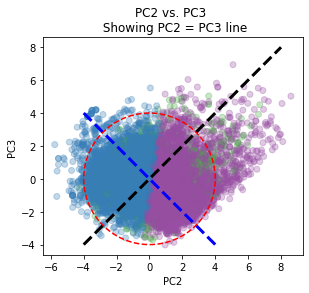

In [36]:
%matplotlib inline
fig, ax = plt.subplots()

ax.scatter(pca.pca_df.PC2, pca.pca_df.PC3, c = group_colors, alpha = .3)
ax.plot([-4,8], [-4,8], color = 'black', linestyle = '--', linewidth = 3)
ax.plot([-4,4],[4,-4], color = 'blue', linestyle = '--', linewidth = 3)

t = np.linspace(0, 2*np.pi, 100)
x = 4*np.cos(t)
y = 4*np.sin(t)
ax.plot(x,y, color = 'red', linestyle = '--')
ax.set(xlabel = 'PC2', ylabel='PC3')

# ax.axhline(y=0, color = 'purple')
ax.set(title = 'PC2 vs. PC3 \n Showing PC2 = PC3 line', aspect = 'equal')
fig.savefig('pc23.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

The circle shows a region of radius 2 around the center. We can see below it is roughly normal within that circle. 

PC2/PC3 histogram contour and 3d plot

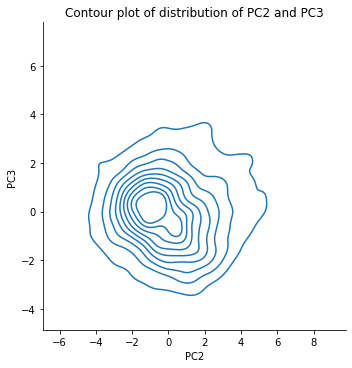

In [37]:
%matplotlib inline
sns.displot(pca.pca_df, x="PC2", y="PC3", kind="kde")
plt.title('Contour plot of distribution of PC2 and PC3')
plt.savefig('pc23_kde.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

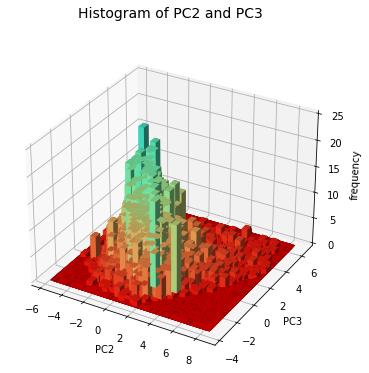

In [38]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
x, y = pca.pca_df.PC2.values, pca.pca_df.PC3.values
hist, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[-6, 8], [-4, 6]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

color = plt.cm.rainbow_r(np.log(hist.ravel()/30+1))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color = color)
ax.set(xlabel = 'PC2', ylabel = 'PC3', zlabel = 'frequency')
ax.set_title('Histogram of PC2 and PC3\n', fontsize = 14)
plt.show()
fig.savefig('pc23_hist.png', dpi = 320, bbox_inches = 'tight', pad_inches = 1)

Hence, the circle roughly shows two standard deviations from this center. However, the data have an outlying section which is entirely outside the CI, and lies almost entirely within the region where 0 < pc2 < pc3; i.e. between the line pc2=pc3 and pc3=0. 

These data also distributed parallel to the line pc2=pc3, with decaying distribution perpendicular to this line.

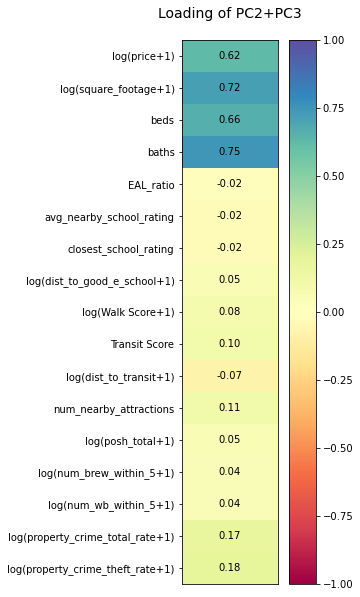

In [39]:
#The vector p2+p3 goes along this line goes with this PCA loading
# Moving along this line is basically larger houses that are further out with lower education, but also lower EAL ratio, and slightly lower crime
%matplotlib inline
pc2, pc3 = pc[1], pc[2]

fig, ax = plt.subplots(figsize = (4,10))
ax.set_title('Loading of PC2+PC3\n', fontsize = 14)
component_plotter(pc2+pc3,fig,ax)
fig.savefig('pc23_loading.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

The data decays as you move down, perpendicular to the pc2=pc3 line. That is, the data get sparser as pc2-pc3 increases. This component is:

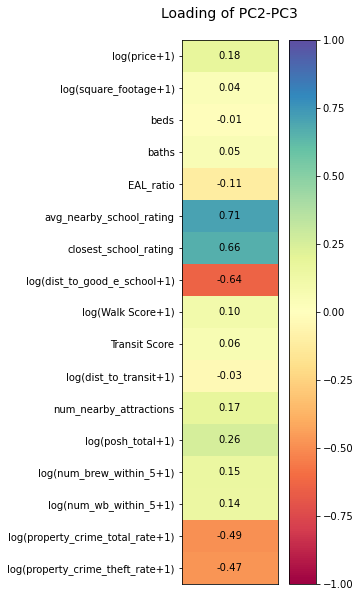

In [40]:
fig, ax = plt.subplots(figsize = (4,10))
ax.set_title('Loading of PC2-PC3\n', fontsize = 14)
component_plotter(pc2-pc3,fig,ax)
fig.savefig('pc2m3_loading.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

Decreased school ratings, higher crime, and fewer attractions. 

Within these outliers, the distribution decays as pc2+pc3 increases or pc2-pc3 increases. However, the distribution along pc2-pc3 looks fairly similar as we move along pc2+pc3. For each further out/larger house type, there is a decaying distribution in the direction above (decreased school rating, higher crime, less stuff to do)

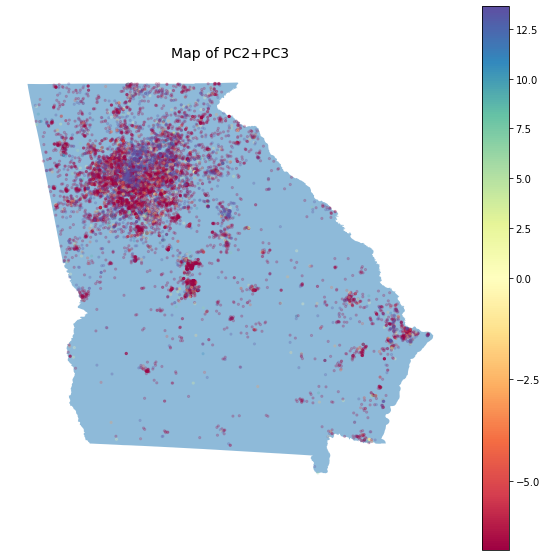

In [41]:
values = pca_coord['PC2'] + pca_coord['PC3']

mappable = cm.ScalarMappable(norm = colors.TwoSlopeNorm(vmin=values.min(), vcenter=0., vmax=values.max()), cmap = cm.Spectral)

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(pca_coord).plot(ax = ax, markersize = 5, alpha = .2, c = mappable.get_cmap()(values))
fig.colorbar(mappable, ax=ax)
ax.set_title('Map of PC2+PC3', fontsize = 14)
plt.axis('off')
fig.savefig('pc23_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = 0.01)

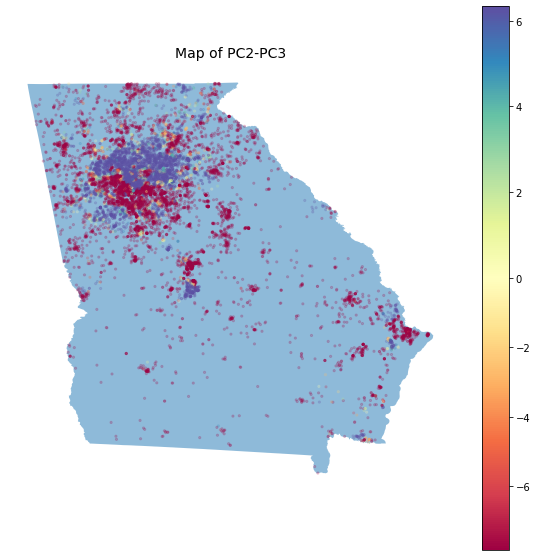

In [42]:
%matplotlib inline
values = pca_coord['PC2'] - pca_coord['PC3']

mappable = cm.ScalarMappable(norm = colors.TwoSlopeNorm(vmin=values.min(), vcenter=0., vmax=values.max()), cmap = cm.Spectral)

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(pca_coord).plot(ax = ax, markersize = 5, alpha = .2, c = mappable.get_cmap()(values))
fig.colorbar(mappable, ax=ax)
ax.set_title('Map of PC2-PC3', fontsize = 14)
plt.axis('off')
fig.savefig('pc2m3_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = 0.01)

## 1,2,4

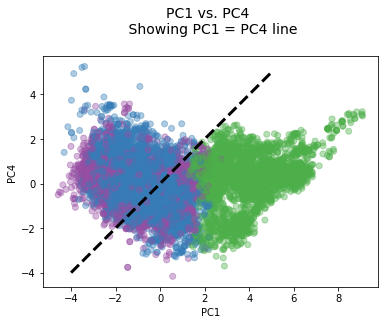

In [77]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (6,5))

ax.scatter(pca.pca_df.PC1, pca.pca_df.PC4, c = major_groups, cmap = triple, alpha = .4)
ax.plot([-4,5], [-4,5], color = 'black', linestyle = '--', linewidth = 3)


# t = np.linspace(0, 2*np.pi, 100)
# x = 2*np.cos(t)-2
# y = 2*np.sin(t)
# ax.plot(x,y, color = 'red', linestyle = '--')

ax.set(xlabel = 'PC1', ylabel='PC4')
# ax.axhline(y=0, color = 'purple')
ax.set(aspect = 'equal')
ax.set_title('PC1 vs. PC4 \n Showing PC1 = PC4 line\n', fontsize = 14)
# fig.savefig('pc14.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

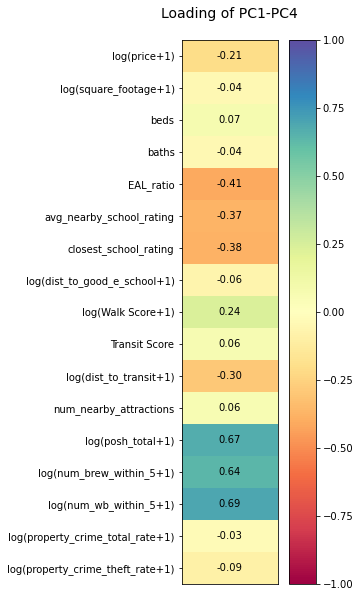

In [44]:
pc1, pc4 = pc[0], pc[3]
fig, ax = plt.subplots(figsize = (4,10))
ax.set_title('Loading of PC1-PC4\n', fontsize = 14)
component_plotter(pc1-pc4,fig,ax)
# fig.savefig('pc1m4_loading.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

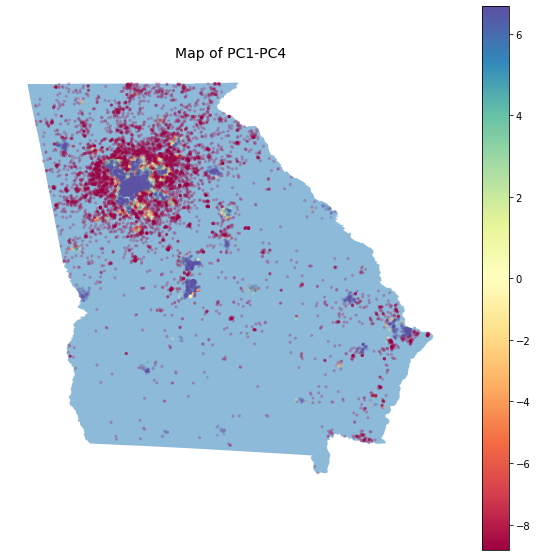

In [45]:
%matplotlib inline
values = pca_coord['PC1'] - pca_coord['PC4']

mappable = cm.ScalarMappable(norm = colors.TwoSlopeNorm(vmin=values.min(), vcenter=0., vmax=values.max()), cmap = cm.Spectral)

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(pca_coord).plot(ax = ax, markersize = 5, alpha = .2, c = mappable.get_cmap()(values))
fig.colorbar(mappable, ax=ax)
ax.set_title('Map of PC1-PC4', fontsize = 14)
plt.axis('off')
# fig.savefig('pc14_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = 0.01)

(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

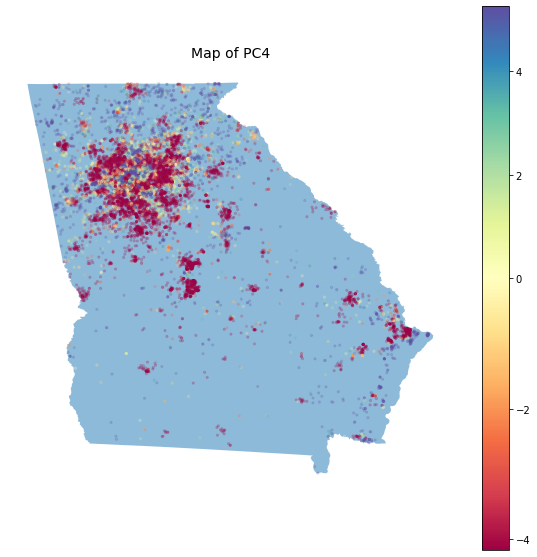

In [46]:
%matplotlib inline
values = pca_coord['PC4']

mappable = cm.ScalarMappable(norm = colors.TwoSlopeNorm(vmin=values.min(), vcenter=0., vmax=values.max()), cmap = cm.Spectral)

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(pca_coord).plot(ax = ax, markersize = 5, alpha = .2, c = mappable.get_cmap()(values))
fig.colorbar(mappable, ax=ax)
ax.set_title('Map of PC4', fontsize = 14)
plt.axis('off')
# fig.savefig('pc4_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = 0.01)

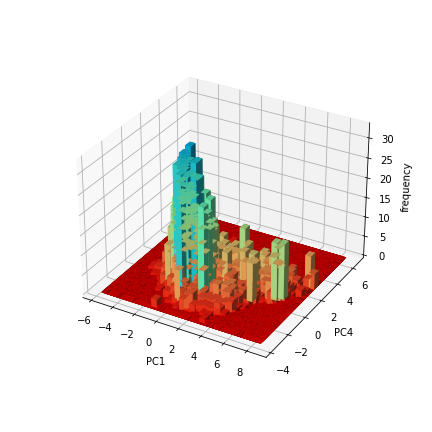

In [47]:
%matplotlib widget
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
x, y = pca.pca_df.PC1.values, pca.pca_df.PC4.values
hist, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[-6, 8], [-4, 6]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

color = plt.cm.rainbow_r(np.log(hist.ravel()/30+1))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color = color)
ax.set(xlabel = 'PC1', ylabel = 'PC4', zlabel = 'frequency')

plt.show()

In [48]:
# %matplotlib inline
# pc1, pc4 = pc[0], pc[3]
# fig, ax = plt.subplots(figsize = (4,10))
# component_plotter(6*pc1 + pc4+pc3, fig, ax)

## 2,3,4

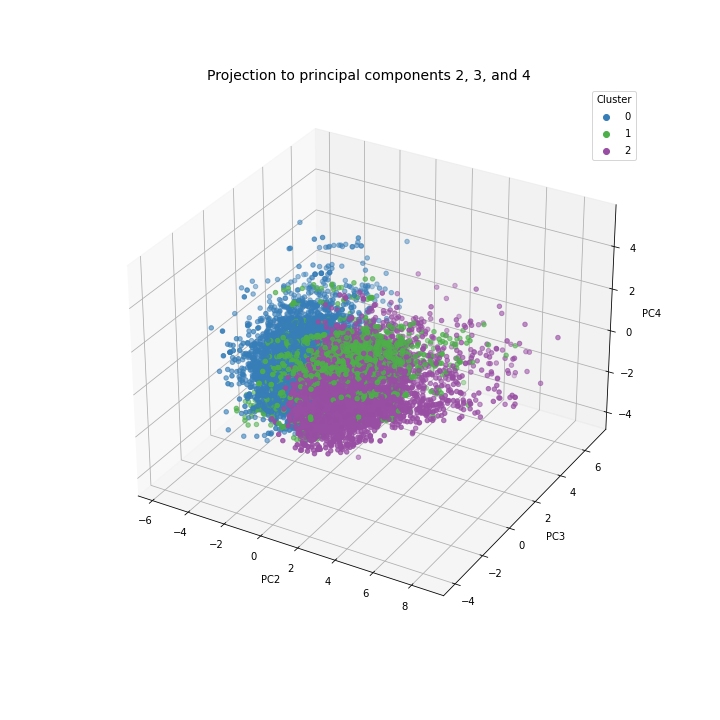

In [78]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = '3d')
feature_grapher(pca.pca_df, [2,3,4], c = major_groups, cmap = triple, fig = fig, ax = ax, legend=True)
# fig.savefig('pc234.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [59]:
#plotly version
px_colors = [*map(lambda x: f'rgb({x[0]}, {x[1]}, {x[2]})', 255 * cm.Set1(np.arange(3)+1))]
fig = px.scatter_3d(pd.concat([pca.pca_df,pd.Series(np.char.array('Cluster ') + np.char.array(major_groups.astype('str')), name = 'Cluster')], axis = 1), 
                    x='PC2', y='PC3', z='PC4', opacity = .8,
                    color = 'Cluster',
                    color_discrete_sequence=px_colors, 
                    category_orders={'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2']},
                    title = 'PCs 2, 3, and 4'
                   )

fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.update_layout(legend= {'itemsizing': 'constant'})
# offline.plot(fig, include_plotlyjs='cdn', filename = 'pc_234.html')

'pc_234.html'

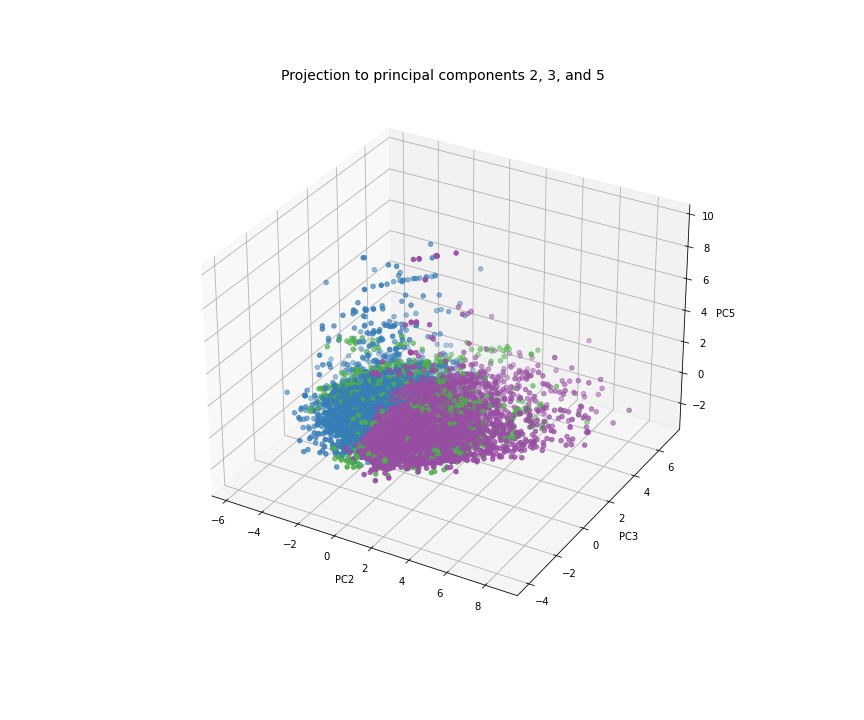

In [50]:
feature_grapher(pca.pca_df, [2,3,5], c = group_colors)

# Exports

In [51]:
# pca_features.to_csv('pca_features_fixed.csv')
# with open('pca_features_fixed.pickle', 'wb') as f:
#     pickle.dump(pca,f)

Something else we can try for versions incorporating LL is using a custom distance metric. The issue with PCA'ing LL is simply that it makes no sense. The standardization would independently skew E-W and N-S values according to their distribution, with the 'mean' being something like a centroid.

Even without using standardization, we may want to use a custom metric which allows us to change the weights of the location vs. similarity.

One idea is to use a metric $k\text{haversine}(x,y)^2 + \text{features}_x\cdot\text{features}_y$. The first term is essentially the actual squared geographic distance between x and y, weighted by k, then summed with the dot product of the remaining features. This would be like as if we had just dotted the features of x and y, except the first features stood for position in a way such that the dot product corresponded to distance as intended. Scaling after finding the haversine distance allows us to reweight the actual distance, and not the coordinates.

In [52]:
pca_features

,latitude,longitude,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,30.781796,-83.558475,-1.087712,-4.072875,1.173210,0.694869,-0.932321,-0.722540,-0.907584,1.636155,0.530063,-0.095298,0.569154,0.515347,-0.274219,-0.425043,-0.002382,-0.159192,-0.004868
1,30.864096,-81.622765,-1.709162,-2.000342,-0.211510,2.000333,4.126861,1.555867,-0.799667,-0.182998,0.009094,-0.984337,0.438141,-0.391993,0.330756,-0.061797,0.505715,-0.156380,-0.081088
2,30.796300,-81.681675,-1.114923,-0.878383,-3.073484,-0.249945,0.437248,-0.849740,0.158698,0.209371,-0.195310,-0.838485,0.668833,-0.013446,0.825998,-0.005251,-0.711228,0.140800,0.095509
3,30.762972,-81.660240,-1.260848,0.152514,-2.654054,-0.373138,0.572217,-1.033053,-0.149419,0.136158,-0.033961,-0.603382,0.871841,0.196093,0.063984,-0.279338,-0.891119,0.157612,0.110314
4,30.804209,-81.653325,-1.287127,0.848653,-1.976306,-0.744374,-0.169123,-1.204573,-0.465749,-0.137528,-0.542715,-0.866637,0.652468,0.029279,-0.528850,-0.428001,-0.900121,0.055404,0.130788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13081,31.430091,-83.886041,-1.919686,-3.841600,1.848646,0.381820,0.059619,0.586002,-0.278498,-0.449153,0.182519,0.324195,0.836832,-0.230763,0.041422,-0.051321,-0.041920,-0.049429,-0.148579
13082,31.430270,-83.880973,-1.941949,-3.739162,1.273885,0.738311,0.254635,0.234980,-0.132755,-0.356137,0.731644,0.252423,0.449490,0.413754,0.114528,-0.075330,-0.124896,-0.027949,-0.149949
13083,31.627090,-84.007895,-0.991876,-4.417961,1.401009,1.478650,0.728957,-0.236247,-1.127554,-0.939793,0.421956,0.000112,0.055573,-0.027621,0.550534,0.080290,-0.194412,-0.086007,-0.006101
13084,31.545665,-83.839933,-1.881096,-3.198225,1.110339,0.989002,0.053749,0.034354,0.319393,-0.322085,0.440593,-0.040540,-0.057664,-0.023024,0.059626,0.068090,-0.047023,-0.084303,-0.118907


In [53]:
from sklearn.metrics import pairwise_distances
from geography_helper import distances_from_dfs

In [54]:
pairwise_distances(pca.pca_df.values)

array([[0.        , 6.71378066, 6.12816867, ..., 3.46869929, 3.07234799,
        3.46291682],
       [6.71378066, 0.        , 6.11944883, ..., 5.16307889, 5.12570678,
        5.35544786],
       [6.12816867, 6.11944883, 0.        , ..., 6.39233759, 5.38001003,
        5.76421843],
       ...,
       [3.46869929, 5.16307889, 6.39233759, ..., 0.        , 2.42847618,
        2.79459301],
       [3.07234799, 5.12570678, 5.38001003, ..., 2.42847618, 0.        ,
        1.1886057 ],
       [3.46291682, 5.35544786, 5.76421843, ..., 2.79459301, 1.1886057 ,
        0.        ]])

In [55]:
def haverdot(x, k):
    sq_haversine_distances = distances_from_dfs(x,x) ** 2
    features_x = x.drop(['latitude', 'longitude'], axis = 1)
    feature_sq_distances = pairwise_distances(features_x) ** 2
    return k * sq_haversine_distances + feature_sq_distances

In [56]:
pd.DataFrame(haverdot(pca_features,0))

,0,1,2,3,4,5,6,7,8,9,...,13076,13077,13078,13079,13080,13081,13082,13083,13084,13085
0,0.000000,45.074851,37.554451,40.666241,43.332319,70.850878,35.826624,33.860037,70.844833,44.955590,...,14.403685,11.231637,16.107318,15.729022,11.935802,9.939021,8.261291,12.031875,9.439322,11.991793
1,45.074851,0.000000,37.447654,39.183628,48.612781,16.934919,35.727048,42.219008,7.599239,48.199812,...,49.076107,51.975959,49.893563,61.241133,51.888529,30.450929,27.257263,26.657384,26.272870,28.680822
2,37.554451,37.447654,0.000000,2.282334,7.646554,38.199835,2.426486,17.021553,46.540184,3.263985,...,28.627494,31.177666,28.592896,50.242980,29.637781,39.614993,33.582550,40.861980,28.944508,33.226214
3,40.666241,39.183628,2.282334,0.000000,2.625014,31.314976,0.905162,11.694235,43.871501,1.839266,...,31.423880,35.045892,30.043563,55.259610,35.213083,42.448855,36.502213,45.820896,31.874443,35.141098
4,43.332319,48.612781,7.646554,2.625014,0.000000,36.935230,2.669543,8.112490,55.438986,2.251744,...,30.349146,36.519798,29.338198,61.027486,38.103432,45.026128,40.939846,50.999854,35.055510,36.776152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13081,9.939021,30.450929,39.614993,42.448855,45.026128,54.896527,36.164130,34.026859,55.554297,48.257928,...,7.613760,7.841342,11.125778,16.451465,10.557274,0.000000,1.544962,5.817569,3.066785,2.204948
13082,8.261291,27.257263,33.582550,36.502213,40.939846,50.526407,31.407559,31.263463,49.933794,42.942432,...,9.016697,7.452809,10.769725,15.687514,9.329069,1.544962,0.000000,4.457748,1.324419,2.597050
13083,12.031875,26.657384,40.861980,45.820896,50.999854,61.877418,41.332927,36.156638,51.738980,50.056378,...,16.360256,14.965348,22.037249,13.696707,15.059564,5.817569,4.457748,0.000000,5.897497,7.809750
13084,9.439322,26.272870,28.944508,31.874443,35.055510,48.055180,25.972157,25.700897,49.093816,37.163311,...,7.546774,7.491972,7.504055,18.788360,9.185013,3.066785,1.324419,5.897497,0.000000,1.412784


In [57]:
haverdot(pca_features.iloc[:,:7], .5)

array([[0.00000000e+00, 1.71581315e+04, 1.61021094e+04, ...,
        5.33429923e+03, 3.96830146e+03, 4.15535499e+03],
       [1.71581315e+04, 0.00000000e+00, 7.27142541e+01, ...,
        2.93247390e+04, 2.51241845e+04, 2.53775033e+04],
       [1.61021094e+04, 7.27142541e+01, 0.00000000e+00, ...,
        2.87709652e+04, 2.45775945e+04, 2.48450964e+04],
       ...,
       [5.33429923e+03, 2.93247390e+04, 2.87709652e+04, ...,
        0.00000000e+00, 1.70604489e+02, 1.48905329e+02],
       [3.96830146e+03, 2.51241845e+04, 2.45775945e+04, ...,
        1.70604489e+02, 0.00000000e+00, 2.89602056e+00],
       [4.15535499e+03, 2.53775033e+04, 2.48450964e+04, ...,
        1.48905329e+02, 2.89602056e+00, 0.00000000e+00]])